In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from collections import Counter

In [ ]:
#general configuration
IMG_SIZE = (224, 224)
NUM_CLASSES = 3

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#paths to the dataset
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Training_Data.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Test_v2_Data.zip"
valid_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Validation_Data.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Training_Part3_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
valid_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Validation_Part3_GroundTruth.csv"
train_dir = "/content/ISIC-2017_Training_Data"
test_dir = "/content/ISIC-2017_Test_v2_Data"
valid_dir = "/content/ISIC-2017_Validation_Data"

In [ ]:
#................Utility Functions......................

def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)
    df['new_image_id'] = df['image_id'] + ".jpg"
    df['id'] = df['melanoma'].apply(lambda x: 'mel' if x != 0.0 else 'no') + \
               df['seborrheic_keratosis'].apply(lambda x: 'seb' if x != 0.0 else 'no')
    df['label'] = df['id'].apply(lambda x: 0 if x == 'nono' else 2 if x == 'melno' else 1)
    return df

def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)
    class_labels = ['Benign (0)', 'SK (1)', 'Melanoma (2)']

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        print(f"  Class {label} ({class_labels[label]}): {count} samples")

def analyze_image_sizes(image_dir):
    sizes = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                sizes.append((img.shape[1], img.shape[0]))  # (width, height)

    size_counts = Counter(sizes)
    print(f"Total images analyzed = {len(sizes)}")
    print("Most common image sizes include:")
    for size, count in size_counts.most_common(10):
        print(f"{size}: {count} images")

#check that all image-label pairs are accounted for
def check_metadata_consistency(df, image_dir):
    image_files = {f for f in os.listdir(image_dir) if f.endswith(".jpg")}
    label_files = set(df['new_image_id'])
    missing_in_dir = label_files - image_files
    missing_in_csv = image_files - label_files
    print(f"Images in CSV but missing in dir: {len(missing_in_dir)}")
    print(f"Images in dir but missing in CSV: {len(missing_in_csv)}")

#show sample images
def show_sample_images(df, image_dir, num_samples=6):
    sample_df = df.sample(num_samples, random_state=42)  # Random but reproducible
    plt.figure(figsize=(15, 5))

    for i, img_id in enumerate(sample_df['new_image_id']):
        img_path = os.path.join(image_dir, img_id)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {sample_df.iloc[i]['label']}")
        plt.axis('off')

    plt.suptitle("Sample Training Images")
    plt.tight_layout()
    plt.show()

#show sample images with their superpixels
def show_sample_images_with_superpixels(df, image_dir, num_samples=3):
    sample_df = df.sample(num_samples, random_state=42)
    plt.figure(figsize=(10, num_samples * 3))

    for i, img_id in enumerate(sample_df['new_image_id']):
        base_id = img_id.replace(".jpg", "")
        img_path = os.path.join(image_dir, img_id)
        sp_path = os.path.join(image_dir, f"{base_id}_superpixels.png")

        # Load original image
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load superpixel mask (grayscale or colormap)
        superpixel = cv2.imread(sp_path, cv2.IMREAD_GRAYSCALE)
        if superpixel is not None:
            superpixel = cv2.applyColorMap(superpixel, cv2.COLORMAP_JET)  # Make it colorful

        # Show original
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Original\nLabel: {sample_df.iloc[i]['label']}")
        plt.axis('off')

        # Show superpixel
        plt.subplot(num_samples, 2, 2 * i + 2)
        if superpixel is not None:
            plt.imshow(superpixel)
            plt.title("Superpixels")
        else:
            plt.text(0.5, 0.5, "Superpixel mask\nnot found", ha='center', va='center')
        plt.axis('off')

    plt.suptitle("Sample Images with Superpixels", fontsize=14)
    plt.tight_layout()
    plt.show()

#empirical blur threshold using Laplacian variance
def detect_blurry_images(image_dir, threshold=70.0):
    blurry_count = 0
    total_checked = 0

    for img_name in os.listdir(image_dir):
        # Only process .jpg files, skip any with '_superpixels' in name
        if not img_name.endswith(".jpg"):
            continue
        if "_superpixels" in img_name:
            continue

        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            total_checked += 1
            lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
            if lap_var < threshold:
                blurry_count += 1

    print(f"Checked {total_checked} valid images.")
    print(f"Blurry images (variance < {threshold}): {blurry_count}")

def plot_intensity_histogram(image_dir, sample_size=50):
    pixel_values = []

    valid_images = [f for f in os.listdir(image_dir)
                    if f.endswith(".jpg") and "_superpixels" not in f]

    sampled_images = valid_images[:sample_size]  # or random.sample

    for img_name in sampled_images:
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            #only get a random subset of pixels to save memory
            flat = img.flatten()
            if len(flat) > 50000:
                flat = np.random.choice(flat, 50000, replace=False)
            pixel_values.append(flat)

    #concatenate all arrays efficiently
    all_pixels = np.concatenate(pixel_values)

    #plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(all_pixels, bins=50, color='gray')
    plt.title("Grayscale Pixel Intensity Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

In [ ]:
#extract and load data
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(valid_zip)
train_df = load_and_process_labels(train_csv)
test_df = load_and_process_labels(test_csv)
valid_df = load_and_process_labels(valid_csv)

In [ ]:
#class distribution
show_class_distribution(train_df['label'].values, title="Class Distribution - Training Data")
print("Total number of training images:", len(train_df), "\n")

show_class_distribution(test_df['label'].values, title="Class Distribution - Testing Data")
print('Total number of testing images:', len(test_df), "\n")

show_class_distribution(valid_df['label'].values, title="Class Distribution - Validation Data")
print('Total number of validation images:', len(valid_df), "\n")




Class Distribution - Training Data:
  Class 0 (Benign (0)): 1372 samples
  Class 1 (SK (1)): 254 samples
  Class 2 (Melanoma (2)): 374 samples
Total number of training images: 2000 


Class Distribution - Testing Data:
  Class 0 (Benign (0)): 393 samples
  Class 1 (SK (1)): 90 samples
  Class 2 (Melanoma (2)): 117 samples
Total number of testing images: 600 


Class Distribution - Validation Data:
  Class 0 (Benign (0)): 78 samples
  Class 1 (SK (1)): 42 samples
  Class 2 (Melanoma (2)): 30 samples
Total number of validation images: 150 



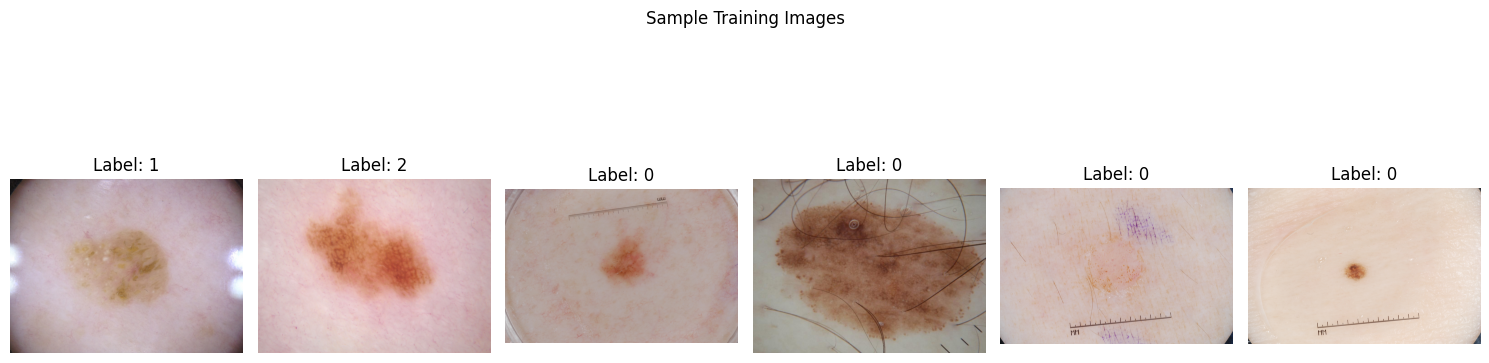

In [ ]:
#show sample training images
show_sample_images(train_df, train_dir, num_samples=6)

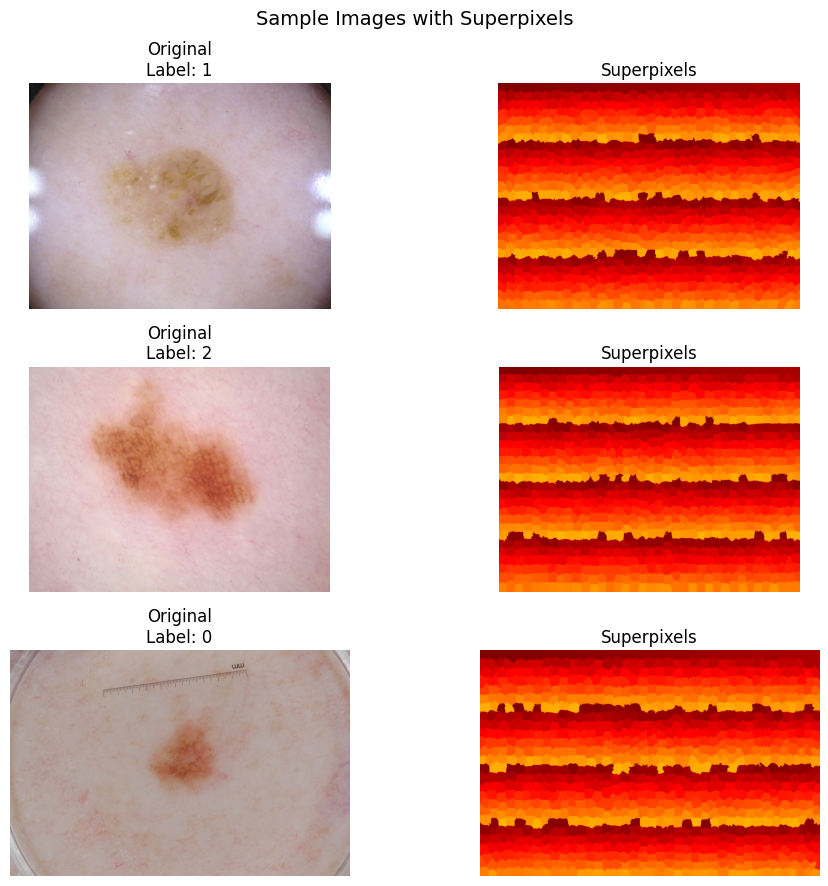

In [ ]:
#show sample training images and super pixels
show_sample_images_with_superpixels(train_df, train_dir, num_samples=3)


In [ ]:
#image and dimension analysis
print("\nImage Size Distribution - Training Set")
analyze_image_sizes(train_dir)

print("\nImage Size Distribution - Test Set")
analyze_image_sizes(test_dir)

print("\nImage Size Distribution - Validation Set")
analyze_image_sizes(valid_dir)


Image Size Distribution - Training Set
Total images analyzed = 2000
Most common image sizes include:
(1024, 768): 499 images
(4288, 2848): 417 images
(3008, 2000): 299 images
(3872, 2592): 96 images
(767, 576): 65 images
(3024, 2016): 61 images
(2048, 1536): 56 images
(3072, 2304): 54 images
(919, 802): 53 images
(1504, 1129): 48 images

Image Size Distribution - Test Set
Total images analyzed = 600
Most common image sizes include:
(4288, 2848): 158 images
(3008, 2000): 116 images
(3872, 2592): 44 images
(6668, 4439): 24 images
(6688, 4439): 23 images
(2592, 1936): 19 images
(6688, 4459): 16 images
(6648, 4439): 15 images
(6708, 4439): 12 images
(6668, 4459): 7 images

Image Size Distribution - Validation Set
Total images analyzed = 150
Most common image sizes include:
(4288, 2848): 41 images
(3008, 2000): 36 images
(3024, 2016): 20 images
(2592, 1936): 15 images
(3872, 2592): 7 images
(6688, 4439): 4 images
(2304, 1536): 2 images
(6688, 4459): 2 images
(6668, 4459): 2 images
(1024, 7

In [ ]:
#metadata consistency
print("\nMetadata Consistency Check")
print("\nTraining data")
check_metadata_consistency(train_df, train_dir)

print("\nTesting data")
check_metadata_consistency(test_df, test_dir)

print("\nValidation data")
check_metadata_consistency(valid_df, valid_dir)


Metadata Consistency Check

Training data
Images in CSV but missing in dir: 0
Images in dir but missing in CSV: 0

Testing data
Images in CSV but missing in dir: 0
Images in dir but missing in CSV: 0

Validation data
Images in CSV but missing in dir: 0
Images in dir but missing in CSV: 0


In [ ]:
#blurry image detection
print("\nBlurry Image Check - Training Data")
detect_blurry_images(train_dir)

print("\nBlurry Image Check - Testing Data")
detect_blurry_images(test_dir)

print("\nBlurry Image Check - Validation Data")
detect_blurry_images(valid_dir)


Blurry Image Check - Training Data
Checked 2000 valid images.
Blurry images (variance < 70.0): 1565

Blurry Image Check - Testing Data
Checked 600 valid images.
Blurry images (variance < 70.0): 570

Blurry Image Check - Validation Data
Checked 150 valid images.
Blurry images (variance < 70.0): 133



Grayscale Intensity Histogram - Training Data


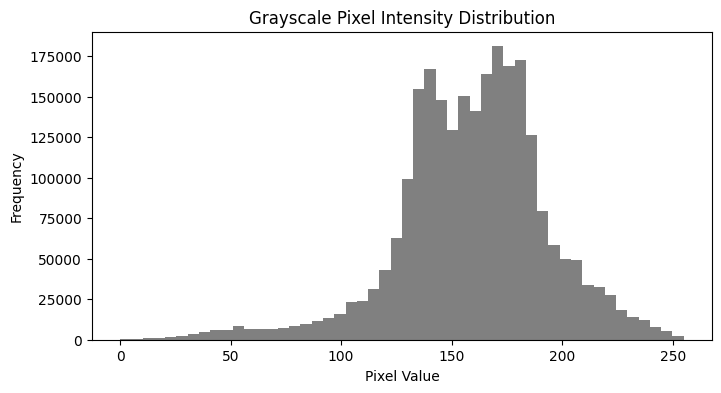


Grayscale Intensity Histogram - Testing Data


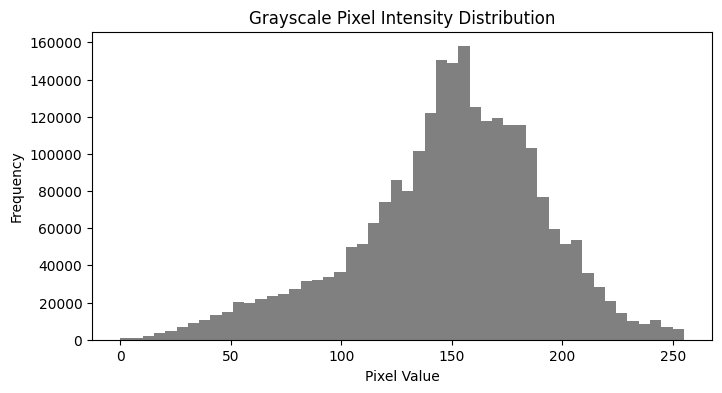


Grayscale Intensity Histogram - Validation Data


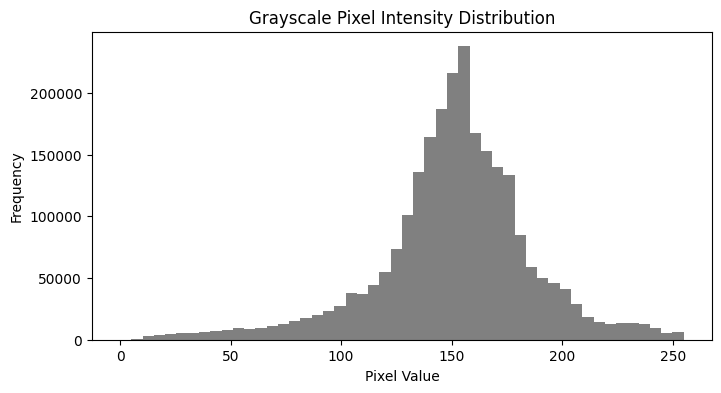

In [ ]:
#pixel intensity distribution
print("\nGrayscale Intensity Histogram - Training Data")
plot_intensity_histogram(train_dir)

print("\nGrayscale Intensity Histogram - Testing Data")
plot_intensity_histogram(test_dir)


print("\nGrayscale Intensity Histogram - Validation Data")
plot_intensity_histogram(valid_dir)